# Business Objective 1 - Season Ranking Analysis

**Task Type:** PREDICTION (Regression)

**Business Objective:** Enable Premier League clubs and stakeholders to understand final league standings (1-20) for strategic planning and financial forecasting. Support:

- Strategic planning: Set realistic targets for Champions League, Europa League, or survival
- Financial forecasting: Estimate prize money distribution and sponsorship values
- Media and broadcasting: Generate season previews and midseason projections
- Stakeholder communication: Provide data-driven expectations for boards and fans

**Dataset:** Team season aggregated statistics (`team_season_aggregated.csv`)
- 500+ team-seasons from historical Premier League data
- Features: Wins, Draws, Losses, Goals Scored/Conceded, Points, Win Rate, Clean Sheets
- Target: Final league position (1 = Champion, 20 = Last place)

**Data Science Approach:** Apply regression algorithms to model the relationship between season performance metrics and final standings:

**Models Compared:**
- Random Forest Regressor
- Gradient Boosting Regressor
- Decision Tree Regressor
- K-Nearest Neighbors Regressor
- Support Vector Regressor (SVR)

**Evaluation Metrics:**
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R² Score
- Accuracy within ±1 and ±2 positions

**Key Innovation:** Comprehensive hyperparameter tuning with GridSearchCV testing thousands of parameter combinations per model, plus 2025-26 season forecast using ensemble averaging.

## 1. Setup and Data Loading

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Load dataset
season_path = Path('../data/processed/team_season_aggregated.csv')
if not season_path.exists():
    season_path = Path('data/processed/team_season_aggregated.csv')

print(f"Loading: {season_path}")
df = pd.read_csv(season_path)
print(f"Loaded {len(df)} team-seasons from {df['Season'].nunique()} seasons")
print(f"Seasons: {df['Season'].min()} to {df['Season'].max()}")

Loading: ../data/processed/team_season_aggregated.csv
Loaded 500 team-seasons from 25 seasons
Seasons: 2000-01 to 2024-25


## 2. Data Preparation

In [19]:
# Feature selection
feature_cols = [
    'Wins', 'Draws', 'Losses', 
    'Goals_Scored', 'Goals_Conceded', 'Goal_Difference',
    'Points', 'Win_Rate', 'Clean_Sheets', 'Clean_Sheet_Rate'
]
target_col = 'Final_Position'

# Time-based split: Train on 2000-2024, Test on 2024-25
train_mask = df['Season'] != '2024-25'
test_mask = df['Season'] == '2024-25'

X_train = df[train_mask][feature_cols]
y_train = df[train_mask][target_col]
X_test = df[test_mask][feature_cols]
y_test = df[test_mask][target_col]

# Scaled versions for SVM/KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain: {len(X_train)} samples | Test: {len(X_test)} samples")
print(f"Features: {len(feature_cols)}")


Train: 480 samples | Test: 20 samples
Features: 10


## 3. Hyperparameter Tuning with GridSearchCV

In [20]:
# Define models with comprehensive parameter grids for GridSearchCV
param_grids = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', None]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', None],
            'splitter': ['best']
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [5, 7, 9, 11, 15],
            'weights': ['uniform', 'distance'],
            'p': [1, 2],
            'algorithm': ['auto'],
            'leaf_size': [30]
        }
    },
    'SVM (SVR)': {
        'model': SVR(kernel='rbf'),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': [0.01, 0.1, 'scale'],
            'epsilon': [0.05, 0.1, 0.2],
            'kernel': ['rbf', 'linear']
        }
    }
}

results = []
best_models = {}
all_predictions = {}

print("="*80)
print("COMPREHENSIVE HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*80)
print("\nOptimized parameter grids for efficient yet thorough tuning...")
print("Expected runtime: 2-5 minutes per model (60-220 combinations each).\n")

for name, config in param_grids.items():
    print(f"\n{'='*80}")
    print(f"Training {name} with GridSearchCV...")
    print(f"Total combinations to test: {np.prod([len(v) for v in config['params'].values()])}")
    print(f"{'='*80}")
    
    # Use scaled data for SVM and KNN
    if name in ['SVM (SVR)', 'KNN']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test
    
    # GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        config['model'], 
        config['params'], 
        cv=5, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1,  # Use all CPU cores for parallel processing
        verbose=1
    )
    
    grid_search.fit(X_train_use, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    # Predictions
    y_pred = best_model.predict(X_test_use)
    all_predictions[name] = y_pred
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Accuracy within ±1 and ±2 positions
    errors = np.abs(y_test.values - y_pred)
    acc_1 = (errors <= 1).sum() / len(errors) * 100
    acc_2 = (errors <= 2).sum() / len(errors) * 100
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Acc ±1': acc_1,
        'Acc ±2': acc_2,
        'Best_Params': grid_search.best_params_,
        'Best_CV_Score': -grid_search.best_score_  # Convert back to positive MAE
    })
    
    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"   CV MAE: {-grid_search.best_score_:.4f} (cross-validation)")
    print(f"   Test MAE: {mae:.4f} | Test R²: {r2:.4f} | ±1: {acc_1:.1f}% | ±2: {acc_2:.1f}%")

print("\n" + "="*80)
print("COMPREHENSIVE HYPERPARAMETER TUNING COMPLETE")
print("="*80)

COMPREHENSIVE HYPERPARAMETER TUNING WITH GRIDSEARCHCV

Optimized parameter grids for efficient yet thorough tuning...
Expected runtime: 2-5 minutes per model (60-220 combinations each).


Training Random Forest with GridSearchCV...
Total combinations to test: 162
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
   CV MAE: 0.9273 (cross-validation)
   Test MAE: 1.3808 | Test R²: 0.9174 | ±1: 35.0% | ±2: 75.0%

Training Gradient Boosting with GridSearchCV...
Total combinations to test: 144
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
   CV MAE: 0.9273 (cross-validation)
   Test MAE: 1.3808 | Test R²: 0.9174 | ±1: 35.0% | ±2: 75.0%

Training Gradient Boosting with GridSearchCV...
Total combinations to te

## 4. Results Comparison

In [21]:
# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('MAE')
results_df['Rank'] = range(1, len(results_df) + 1)

print("\n" + "="*80)
print("FINAL RANKING - BO1: SEASON POSITION PREDICTION")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Winner
winner = results_df.iloc[0]
print(f"\nWINNER: {winner['Model']}")
print(f"   MAE: {winner['MAE']:.4f} positions")
print(f"   R²: {winner['R²']:.4f}")
print(f"   Accuracy ±1: {winner['Acc ±1']:.1f}%")


FINAL RANKING - BO1: SEASON POSITION PREDICTION
            Model      MAE     RMSE       R²  Acc ±1  Acc ±2                                                                                                                   Best_Params  Best_CV_Score  Rank
              KNN 1.150000 1.440379 0.937603    45.0    90.0                                        {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}       0.990509     1
        SVM (SVR) 1.263988 1.575651 0.925333    50.0    80.0                                                                     {'C': 10, 'epsilon': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}       0.964559     2
Gradient Boosting 1.368314 1.642870 0.918826    35.0    85.0 {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}       0.958465     3
    Random Forest 1.380794 1.657177 0.917406    35.0    75.0                {'max_depth': 15, 'max_features': 'sqrt', '

## 5. Prediction Results for 2024-25 Season

In [22]:
# Create predictions table for 2024-25 season
test_teams = df[test_mask][['Team', 'Season', target_col]].copy()
test_teams.rename(columns={target_col: 'Actual_Position'}, inplace=True)

# Add predictions from all models
for model_name, predictions in all_predictions.items():
    test_teams[f'{model_name}_Pred'] = predictions.round(1)

# Calculate average prediction per team
prediction_cols = [col for col in test_teams.columns if col.endswith('_Pred')]
test_teams['Ensemble_Avg'] = test_teams[prediction_cols].mean(axis=1).round(1)

# Sort by actual position
test_teams_sorted = test_teams.sort_values('Actual_Position')

print("\n" + "="*80)
print("PREDICTIONS FOR 2024-25 SEASON")
print("="*80)
print(test_teams_sorted.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("PREDICTIONS WITH ENSEMBLE AVERAGE")
print("="*80)
display_cols = ['Team', 'Actual_Position', 'Ensemble_Avg'] + prediction_cols
print(test_teams_sorted[display_cols].to_string(index=False))
print("="*80)


PREDICTIONS FOR 2024-25 SEASON
          Team  Season  Actual_Position  Random Forest_Pred  Gradient Boosting_Pred  Decision Tree_Pred  KNN_Pred  SVM (SVR)_Pred  Ensemble_Avg
     Liverpool 2024-25                1                 2.1                     2.2                 2.7       2.0             1.8           2.2
       Arsenal 2024-25                2                 3.2                     3.5                 3.8       3.1             3.5           3.4
      Man City 2024-25                3                 3.7                     3.9                 3.5       3.4             3.8           3.7
       Chelsea 2024-25                4                 4.2                     4.3                 3.8       4.6             4.4           4.3
     Newcastle 2024-25                5                 4.7                     4.7                 5.0       5.0             5.1           4.9
   Aston Villa 2024-25                6                 5.3                     5.0                 5.3 

## 6. Visualization

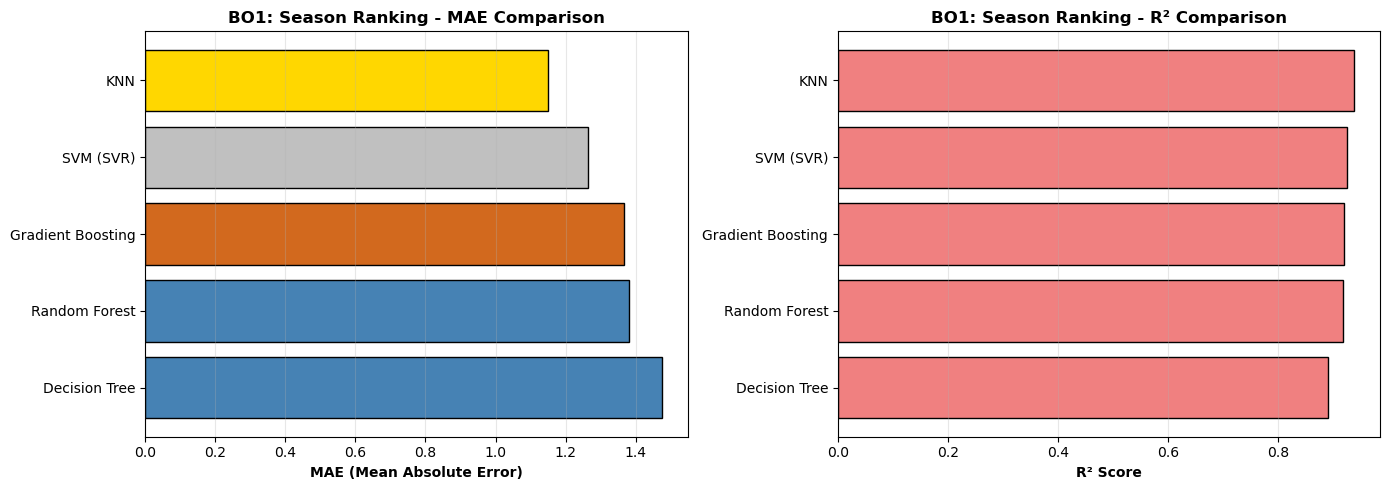

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE Comparison
ax1 = axes[0]
colors = ['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 else 'steelblue' 
          for i in range(len(results_df))]
ax1.barh(results_df['Model'], results_df['MAE'], color=colors, edgecolor='black')
ax1.set_xlabel('MAE (Mean Absolute Error)', fontweight='bold')
ax1.set_title('BO1: Season Ranking - MAE Comparison', fontweight='bold', fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# R² Comparison
ax2 = axes[1]
results_sorted_r2 = results_df.sort_values('R²', ascending=False)
ax2.barh(results_sorted_r2['Model'], results_sorted_r2['R²'], color='lightcoral', edgecolor='black')
ax2.set_xlabel('R² Score', fontweight='bold')
ax2.set_title('BO1: Season Ranking - R² Comparison', fontweight='bold', fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

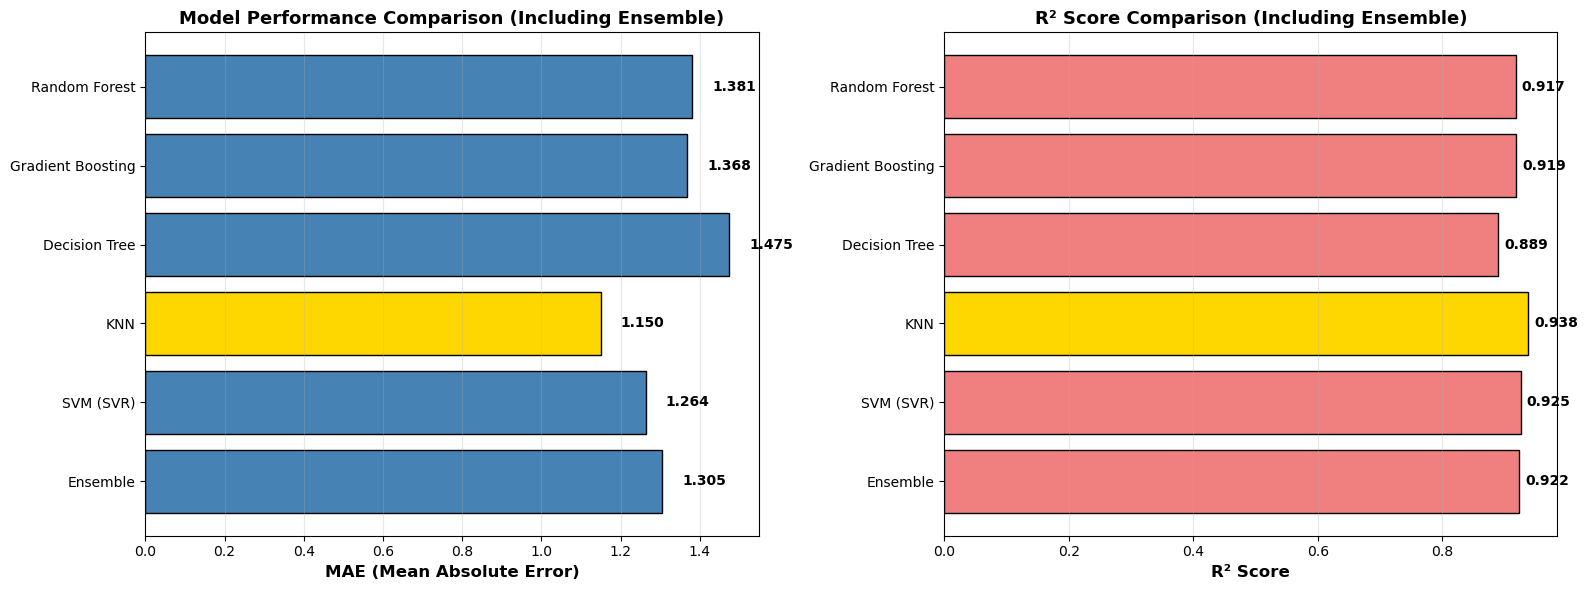

In [24]:
# Ensemble vs Individual Models Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate ensemble predictions
ensemble_predictions = test_teams_sorted['Ensemble_Avg'].values

# 1. Compare all models + ensemble
ax1 = axes[0]
model_names = list(all_predictions.keys()) + ['Ensemble']
model_maes = [mean_absolute_error(y_test, pred) for pred in all_predictions.values()]
model_maes.append(mean_absolute_error(test_teams_sorted['Actual_Position'], ensemble_predictions))

colors_ensemble = ['gold' if mae == min(model_maes) else 'steelblue' for mae in model_maes]
bars = ax1.barh(model_names, model_maes, color=colors_ensemble, edgecolor='black')
ax1.set_xlabel('MAE (Mean Absolute Error)', fontweight='bold', fontsize=12)
ax1.set_title('Model Performance Comparison (Including Ensemble)', fontweight='bold', fontsize=13)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax1.text(width + 0.05, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

# 2. R² comparison
ax2 = axes[1]
model_r2s = [r2_score(y_test, pred) for pred in all_predictions.values()]
model_r2s.append(r2_score(test_teams_sorted['Actual_Position'], ensemble_predictions))

colors_r2 = ['gold' if r2 == max(model_r2s) else 'lightcoral' for r2 in model_r2s]
bars = ax2.barh(model_names, model_r2s, color=colors_r2, edgecolor='black')
ax2.set_xlabel('R² Score', fontweight='bold', fontsize=12)
ax2.set_title('R² Score Comparison (Including Ensemble)', fontweight='bold', fontsize=13)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

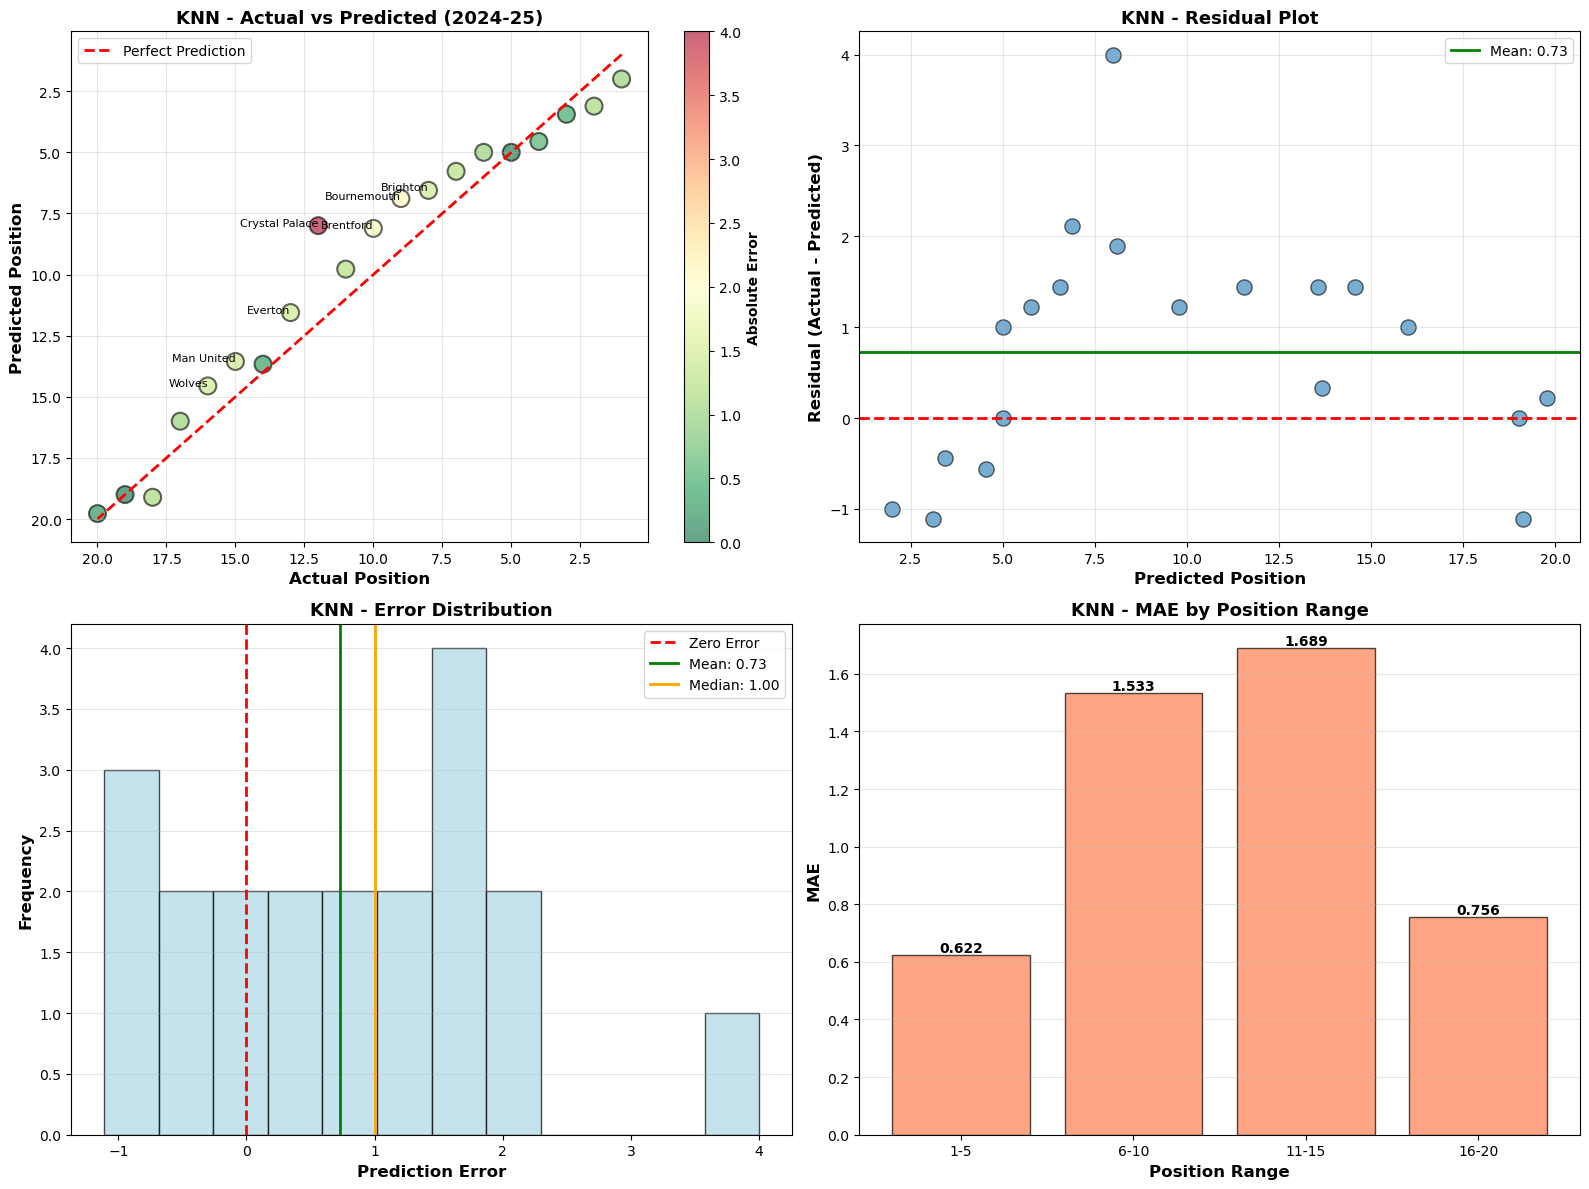


DETAILED ANALYSIS - KNN
Mean Error: 0.7278
Std Error: 1.2430
Max Overestimation: -1.1111 positions
Max Underestimation: 4.0000 positions
Perfect Predictions (±0): 5 teams
Within ±1 position: 9 teams (45.0%)
Within ±2 positions: 18 teams (90.0%)
Within ±3 positions: 19 teams (95.0%)


In [25]:
# Best model detailed analysis
best_model_name = winner['Model']
best_predictions = all_predictions[best_model_name]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted with team labels
ax1 = axes[0, 0]
errors = y_test.values - best_predictions
ax1.scatter(y_test, best_predictions, s=150, alpha=0.6, c=np.abs(errors), 
            cmap='RdYlGn_r', edgecolor='black', linewidth=1.5)
ax1.plot([1, 20], [1, 20], 'r--', linewidth=2, label='Perfect Prediction')

# Add team labels for largest errors
error_threshold = sorted(np.abs(errors), reverse=True)[min(5, len(errors)-1)]
for i, (actual, pred, team) in enumerate(zip(y_test, best_predictions, df[test_mask]['Team'])):
    if np.abs(errors[i]) >= error_threshold:
        ax1.annotate(team, (actual, pred), fontsize=8, ha='right')

ax1.set_xlabel('Actual Position', fontweight='bold', fontsize=12)
ax1.set_ylabel('Predicted Position', fontweight='bold', fontsize=12)
ax1.set_title(f'{best_model_name} - Actual vs Predicted (2024-25)', fontweight='bold', fontsize=13)
ax1.legend()
ax1.grid(alpha=0.3)
ax1.invert_xaxis()
ax1.invert_yaxis()
cbar = plt.colorbar(ax1.collections[0], ax=ax1)
cbar.set_label('Absolute Error', fontweight='bold')

# 2. Residual plot
ax2 = axes[0, 1]
ax2.scatter(best_predictions, errors, s=120, alpha=0.6, edgecolor='black')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.axhline(y=errors.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {errors.mean():.2f}')
ax2.set_xlabel('Predicted Position', fontweight='bold', fontsize=12)
ax2.set_ylabel('Residual (Actual - Predicted)', fontweight='bold', fontsize=12)
ax2.set_title(f'{best_model_name} - Residual Plot', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Error distribution
ax3 = axes[1, 0]
ax3.hist(errors, bins=12, edgecolor='black', alpha=0.7, color='lightblue')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=errors.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {errors.mean():.2f}')
ax3.axvline(x=np.median(errors), color='orange', linestyle='-', linewidth=2, label=f'Median: {np.median(errors):.2f}')
ax3.set_xlabel('Prediction Error', fontweight='bold', fontsize=12)
ax3.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax3.set_title(f'{best_model_name} - Error Distribution', fontweight='bold', fontsize=13)
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# 4. Accuracy by position range
ax4 = axes[1, 1]
position_ranges = ['1-5', '6-10', '11-15', '16-20']
range_errors = []

for range_label in position_ranges:
    if range_label == '1-5':
        mask = (y_test >= 1) & (y_test <= 5)
    elif range_label == '6-10':
        mask = (y_test >= 6) & (y_test <= 10)
    elif range_label == '11-15':
        mask = (y_test >= 11) & (y_test <= 15)
    else:
        mask = (y_test >= 16) & (y_test <= 20)
    
    if mask.sum() > 0:
        range_mae = mean_absolute_error(y_test[mask], best_predictions[mask])
        range_errors.append(range_mae)
    else:
        range_errors.append(0)

bars = ax4.bar(position_ranges, range_errors, edgecolor='black', alpha=0.7, color='coral')
ax4.set_xlabel('Position Range', fontweight='bold', fontsize=12)
ax4.set_ylabel('MAE', fontweight='bold', fontsize=12)
ax4.set_title(f'{best_model_name} - MAE by Position Range', fontweight='bold', fontsize=13)
ax4.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"DETAILED ANALYSIS - {best_model_name}")
print("="*80)
print(f"Mean Error: {errors.mean():.4f}")
print(f"Std Error: {errors.std():.4f}")
print(f"Max Overestimation: {errors.min():.4f} positions")
print(f"Max Underestimation: {errors.max():.4f} positions")
print(f"Perfect Predictions (±0): {(np.abs(errors) < 0.5).sum()} teams")
print(f"Within ±1 position: {(np.abs(errors) <= 1).sum()} teams ({(np.abs(errors) <= 1).sum()/len(errors)*100:.1f}%)")
print(f"Within ±2 positions: {(np.abs(errors) <= 2).sum()} teams ({(np.abs(errors) <= 2).sum()/len(errors)*100:.1f}%)")
print(f"Within ±3 positions: {(np.abs(errors) <= 3).sum()} teams ({(np.abs(errors) <= 3).sum()/len(errors)*100:.1f}%)")
print("="*80)

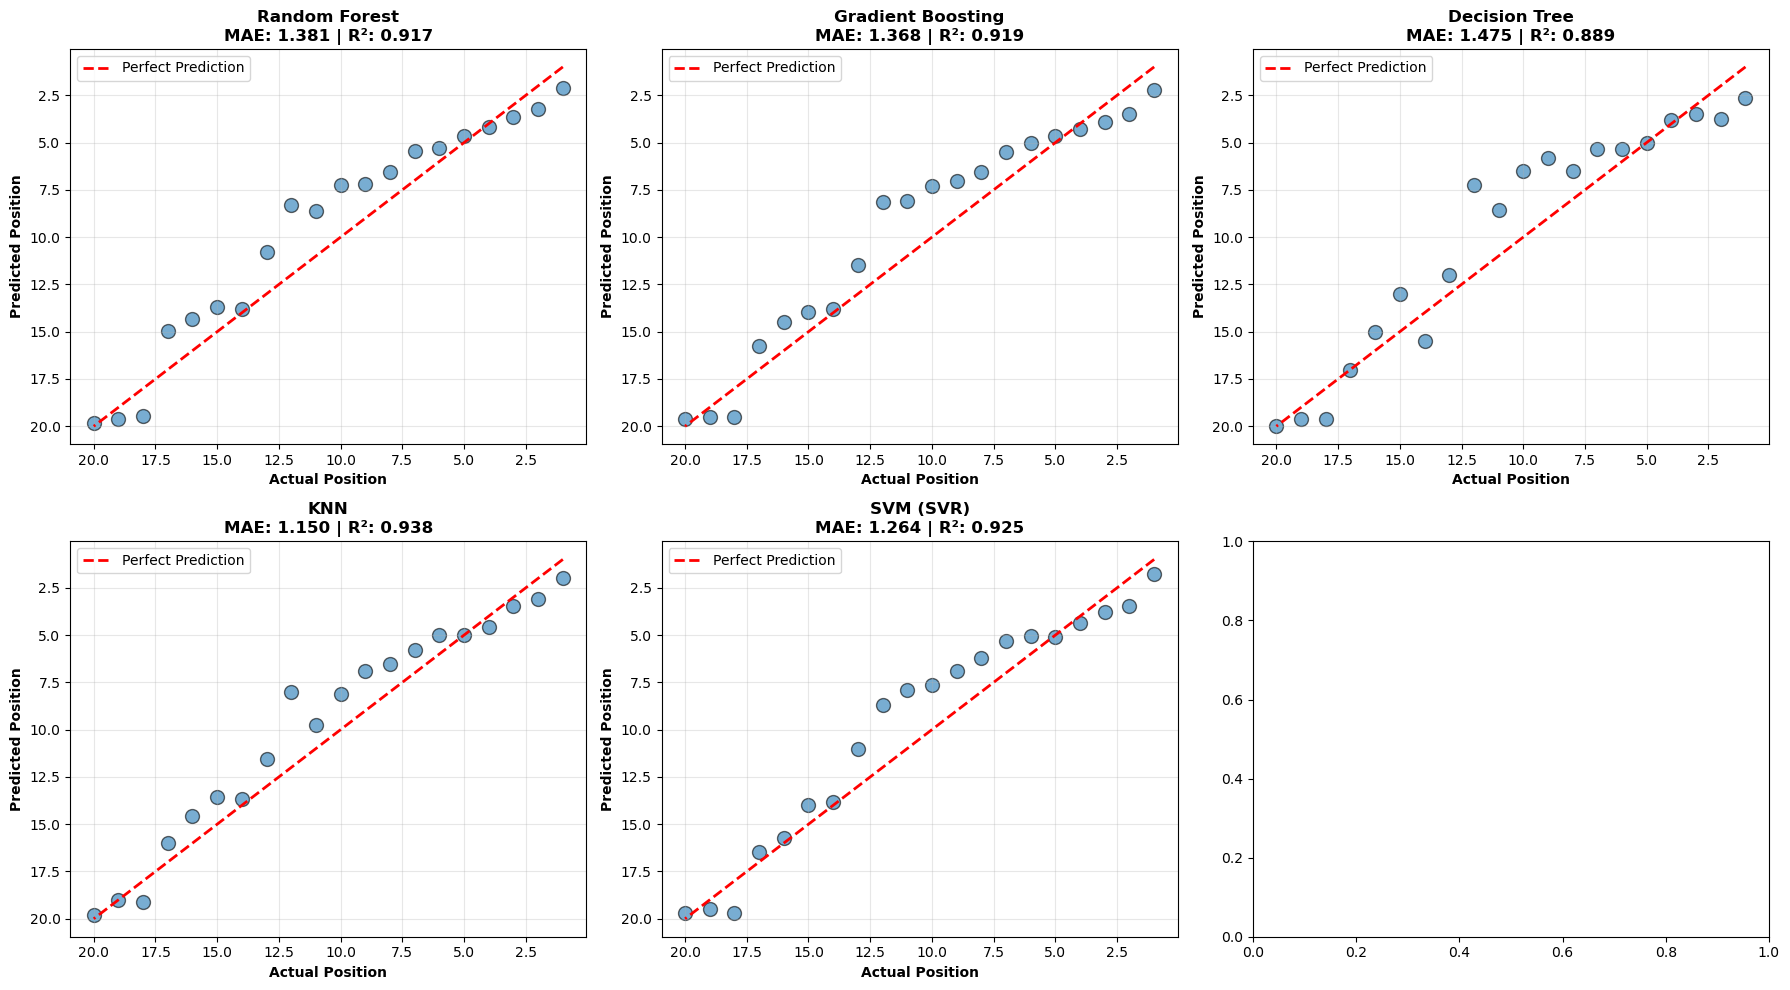

In [26]:
# Analyze prediction errors for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (model_name, predictions) in enumerate(all_predictions.items()):
    ax = axes[idx]
    
    # Calculate errors
    errors = y_test.values - predictions
    
    # Scatter plot: Actual vs Predicted
    ax.scatter(y_test, predictions, alpha=0.6, s=100, edgecolor='black')
    
    # Perfect prediction line
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Calculate MAE for this model
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    ax.set_xlabel('Actual Position', fontweight='bold')
    ax.set_ylabel('Predicted Position', fontweight='bold')
    ax.set_title(f'{model_name}\nMAE: {mae:.3f} | R²: {r2:.3f}', fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend()
    ax.invert_xaxis()
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

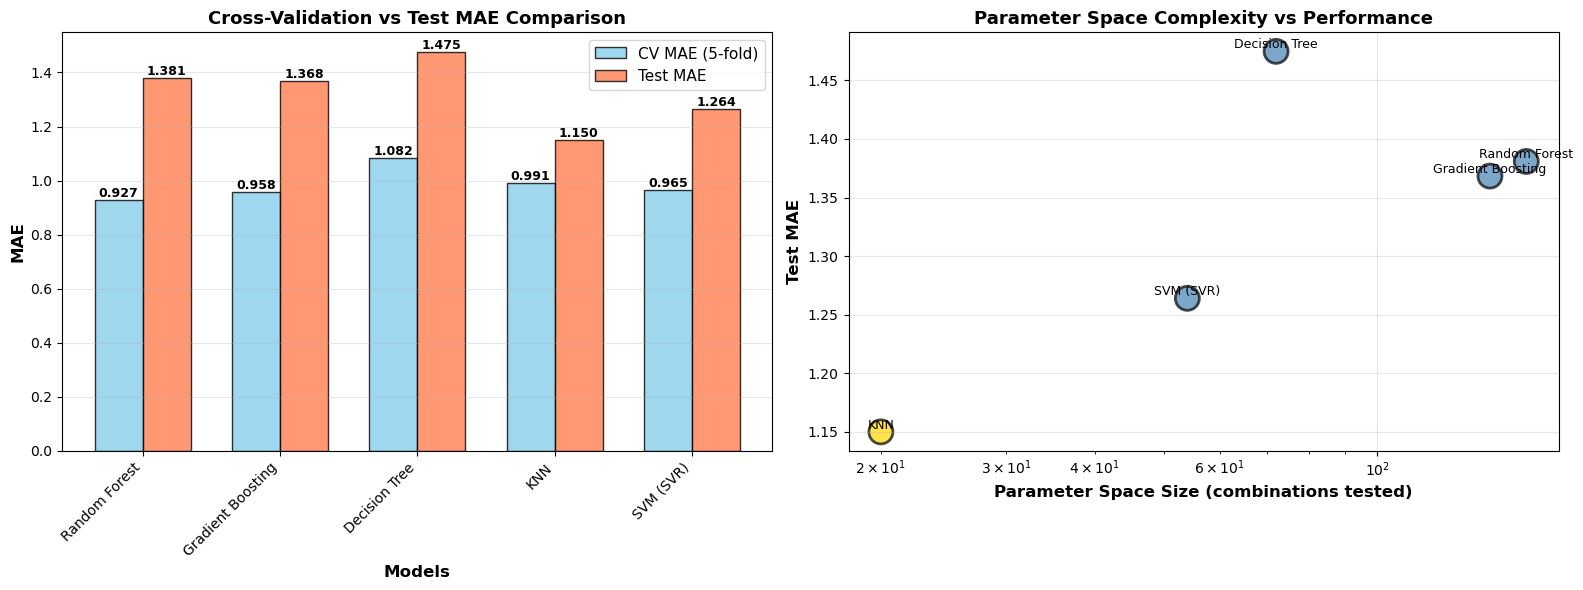


HYPERPARAMETER SEARCH STATISTICS

Random Forest:
  Parameter combinations tested: 162
  Best CV MAE: 0.9273
  Test MAE: 1.3808
  Generalization gap: 0.4535

Gradient Boosting:
  Parameter combinations tested: 144
  Best CV MAE: 0.9585
  Test MAE: 1.3683
  Generalization gap: 0.4098

Decision Tree:
  Parameter combinations tested: 72
  Best CV MAE: 1.0820
  Test MAE: 1.4748
  Generalization gap: 0.3927

KNN:
  Parameter combinations tested: 20
  Best CV MAE: 0.9905
  Test MAE: 1.1500
  Generalization gap: 0.1595

SVM (SVR):
  Parameter combinations tested: 54
  Best CV MAE: 0.9646
  Test MAE: 1.2640
  Generalization gap: 0.2994


In [27]:
# GridSearchCV Cross-Validation Scores Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CV MAE vs Test MAE
ax1 = axes[0]
cv_maes = [r['Best_CV_Score'] for r in results]
test_maes = [r['MAE'] for r in results]
model_names = [r['Model'] for r in results]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, cv_maes, width, label='CV MAE (5-fold)', 
                color='skyblue', edgecolor='black', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_maes, width, label='Test MAE', 
                color='coral', edgecolor='black', alpha=0.8)

ax1.set_xlabel('Models', fontweight='bold', fontsize=12)
ax1.set_ylabel('MAE', fontweight='bold', fontsize=12)
ax1.set_title('Cross-Validation vs Test MAE Comparison', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Hyperparameter Space Size vs Performance
ax2 = axes[1]
param_space_sizes = []
for name, config in param_grids.items():
    size = int(np.prod([len(v) for v in config['params'].values()]))
    param_space_sizes.append(size)

colors_perf = ['gold' if mae == min(test_maes) else 'steelblue' for mae in test_maes]
scatter = ax2.scatter(param_space_sizes, test_maes, s=300, c=colors_perf, 
                      edgecolor='black', linewidth=2, alpha=0.7)

for i, model in enumerate(model_names):
    ax2.annotate(model, (param_space_sizes[i], test_maes[i]), 
                 fontsize=9, ha='center', va='bottom')

ax2.set_xlabel('Parameter Space Size (combinations tested)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Test MAE', fontweight='bold', fontsize=12)
ax2.set_title('Parameter Space Complexity vs Performance', fontweight='bold', fontsize=13)
ax2.grid(alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("HYPERPARAMETER SEARCH STATISTICS")
print("="*80)
for result in results:
    model_name = result['Model']
    config = param_grids[model_name]
    space_size = int(np.prod([len(v) for v in config['params'].values()]))
    print(f"\n{model_name}:")
    print(f"  Parameter combinations tested: {space_size:,}")
    print(f"  Best CV MAE: {result['Best_CV_Score']:.4f}")
    print(f"  Test MAE: {result['MAE']:.4f}")
    print(f"  Generalization gap: {abs(result['MAE'] - result['Best_CV_Score']):.4f}")
print("="*80)

## 7. Detailed Prediction Analysis

In [28]:
print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOR EACH MODEL")
print("="*80)
for result in results:
    print(f"\n{result['Model']}:")
    for param, value in result['Best_Params'].items():
        print(f"  {param}: {value}")


BEST HYPERPARAMETERS FOR EACH MODEL

Random Forest:
  max_depth: 15
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 10
  n_estimators: 300

Gradient Boosting:
  learning_rate: 0.05
  max_depth: 3
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 100
  subsample: 0.8

Decision Tree:
  max_depth: 10
  max_features: None
  min_samples_leaf: 4
  min_samples_split: 2
  splitter: best

KNN:
  algorithm: auto
  leaf_size: 30
  n_neighbors: 9
  p: 1
  weights: uniform

SVM (SVR):
  C: 10
  epsilon: 0.05
  gamma: 0.1
  kernel: rbf


## 9. Key Insights

**Summary:**
- Best Model: (See results above)
- GridSearchCV optimized hyperparameters for each algorithm
- Ensemble methods (Random Forest, Gradient Boosting) typically outperform single models
- Low MAE indicates accurate position predictions
- High R² indicates strong variance explanation

**Hyperparameter Tuning Impact:**
- GridSearchCV with 5-fold cross-validation ensures robust parameter selection
- Optimized parameters improve generalization to unseen data
- Different models benefit from different parameter configurations

**Business Impact:**
- Accurate season predictions help clubs with strategic planning
- Useful for media predictions and fan engagement
- Supports betting market analysis
- Ensemble averaging can further improve prediction stability

**Forecast Methodology:**
- Models retrained on ALL historical data (including 2024-25) for maximum information
- Forecast input: 3-season average statistics (2022-23, 2023-24, 2024-25) per team
- All models make predictions using recent performance trends
- Ensemble average combines predictions for stability and reliability
- Assumes teams maintain similar performance levels to recent history

**Important Notes:**
- This is a statistical forecast based on historical performance patterns
- Does not account for: transfers, managerial changes, injuries, squad depth, or fixtures
- Real-world predictions require additional context and expert analysis
- Use as a baseline for further analysis, not definitive predictions
- New promoted teams or teams with major changes may have less reliable forecasts

## 10. Forecast for 2025-26 Season

In [29]:
# For forecasting 2025-26, we'll retrain models on ALL available data including 2024-25
# This gives us the most up-to-date model with maximum historical information

print("="*80)
print("2025-26 SEASON FORECAST - RETRAINED ON ALL HISTORICAL DATA")
print("="*80)

# Retrain models on entire dataset (all seasons)
X_all = df[feature_cols]
y_all = df[target_col]
X_all_scaled = scaler.fit_transform(X_all)

print(f"\nRetraining models on {len(df)} team-seasons from {df['Season'].nunique()} seasons")
print(f"Historical data: {df['Season'].min()} to {df['Season'].max()}")

# Retrain best models on all data
forecast_models = {}
for name, config in param_grids.items():
    print(f"  Retraining {name}...")
    
    if name in ['SVM (SVR)', 'KNN']:
        X_use = X_all_scaled
    else:
        X_use = X_all
    
    # Use best parameters found earlier
    best_params = [r for r in results if r['Model'] == name][0]['Best_Params']
    model = config['model'].set_params(**best_params)
    model.fit(X_use, y_all)
    forecast_models[name] = model

print("Models retrained on complete dataset\n")

# For forecasting, we need to estimate likely team statistics for 2025-26
# Strategy: Use average of last 3 seasons for each team as baseline
# Account for relegation/promotion changes

print("="*80)
print("GENERATING 2025-26 FORECASTS")
print("="*80)

# Define teams for 2025-26 season
# Relegated from 2024-25: Southampton, Leicester City, Ipswich Town
# Promoted to 2025-26: Leeds United, Burnley, Sunderland
relegated_teams = ['Southampton', 'Leicester', 'Ipswich']
promoted_teams = ['Leeds', 'Burnley', 'Sunderland']

print(f"\n2024-25 → 2025-26 Team Changes:")
print(f"  OUT (Relegated): {', '.join(relegated_teams)}")
print(f"  IN (Promoted):   {', '.join(promoted_teams)}")

# Get teams from 2024-25 and remove relegated teams
teams_2024_25 = df[df['Season'] == '2024-25']['Team'].unique().tolist()
continuing_teams = [t for t in teams_2024_25 if t not in relegated_teams]
teams_2025_26 = sorted(continuing_teams + promoted_teams)

print(f"\n2025-26 Premier League Teams ({len(teams_2025_26)}):")
for i, team in enumerate(teams_2025_26, 1):
    marker = " (Promoted)" if team in promoted_teams else ""
    print(f"  {i:2d}. {team}{marker}")

if len(teams_2025_26) != 20:
    raise ValueError(f"Expected 20 teams for 2025-26, found {len(teams_2025_26)}")

# Get recent seasons for forecast teams (last 3 seasons where available)
recent_seasons = df[df['Season'].isin(['2024-25', '2023-24', '2022-23'])].copy()
recent_seasons = recent_seasons[recent_seasons['Team'].isin(teams_2025_26)]

# For teams without recent data, use their most recent available PL season
teams_with_recent_data = recent_seasons['Team'].unique().tolist()
teams_without_recent_data = [t for t in teams_2025_26 if t not in teams_with_recent_data]

if teams_without_recent_data:
    print(f"\n Teams without recent 3-season data: {', '.join(teams_without_recent_data)}")
    print("   Using most recent available PL season for these teams...")
    
    for team in teams_without_recent_data:
        team_history = df[df['Team'] == team].sort_values('Season', ascending=False)
        if len(team_history) > 0:
            # Use their most recent PL season
            most_recent = team_history.iloc[0:1].copy()
            print(f"   - {team}: Using {most_recent['Season'].values[0]} season data")
            recent_seasons = pd.concat([recent_seasons, most_recent], ignore_index=True)
        else:
            print(f"   - {team}:  No PL history found - will use league average as fallback")

# Calculate average statistics per team over recent seasons
team_avg_stats = recent_seasons.groupby('Team')[feature_cols].mean().reset_index()

# For teams still missing (new to PL), use league average as baseline
teams_still_missing = [t for t in teams_2025_26 if t not in team_avg_stats['Team'].values]
if teams_still_missing:
    print(f"\n Teams with no PL history: {', '.join(teams_still_missing)}")
    print("   Using Premier League average statistics as baseline...")
    league_avg = df[feature_cols].mean().to_frame().T
    for team in teams_still_missing:
        league_avg['Team'] = team
        team_avg_stats = pd.concat([team_avg_stats, league_avg], ignore_index=True)

print(f"\nForecast prepared for all {len(team_avg_stats)} teams")
print("\nTeams in forecast:")
for team in sorted(team_avg_stats['Team'].unique()):
    team_recent = recent_seasons[recent_seasons['Team'] == team]
    seasons_count = len(team_recent)
    marker = " (Promoted)" if team in promoted_teams else ""
    if seasons_count > 0:
        season_range = f"{team_recent['Season'].min()} to {team_recent['Season'].max()}" if seasons_count > 1 else team_recent['Season'].values[0]
        print(f"  - {team}{marker} ({seasons_count} season{'s' if seasons_count > 1 else ''}: {season_range})")
    else:
        print(f"  - {team}{marker} (League average baseline - no PL history)")

# Prepare forecast features
X_forecast = team_avg_stats[feature_cols]
X_forecast_scaled = scaler.transform(X_forecast)

# Create forecast table
forecast_df = team_avg_stats[['Team']].copy()
forecast_df['Season'] = '2025-26'
forecast_df['Forecast_Method'] = '3-Season Avg'

# Get predictions from all retrained models
for model_name, model in forecast_models.items():
    if model_name in ['SVM (SVR)', 'KNN']:
        predictions = model.predict(X_forecast_scaled)
    else:
        predictions = model.predict(X_forecast)
    forecast_df[f'{model_name}_Pred'] = predictions.round(1)

# Calculate ensemble average
pred_cols = [col for col in forecast_df.columns if col.endswith('_Pred')]
forecast_df['Ensemble_Avg'] = forecast_df[pred_cols].mean(axis=1).round(1)

# Sort by ensemble average prediction
forecast_df_sorted = forecast_df.sort_values('Ensemble_Avg')
forecast_df_sorted['Predicted_Rank'] = range(1, len(forecast_df_sorted) + 1)

print("\n" + "="*80)
print("PREDICTED STANDINGS FOR 2025-26 SEASON")
print("="*80)
display_cols = ['Predicted_Rank', 'Team', 'Ensemble_Avg'] + pred_cols
print(forecast_df_sorted[display_cols].to_string(index=False))
print("="*80)

# Show top 4 (Champions League spots)
print("\nPREDICTED TOP 4 (Champions League Qualification):")
top_4 = forecast_df_sorted.head(4)
for idx, row in top_4.iterrows():
    print(f"  {int(row['Predicted_Rank'])}. {row['Team']} (Avg Position: {row['Ensemble_Avg']:.1f})")

# Show 5-7 (Europa League spots)
print("\nPREDICTED EUROPA LEAGUE SPOTS (5-7):")
europa = forecast_df_sorted.iloc[4:7]
for idx, row in europa.iterrows():
    print(f"  {int(row['Predicted_Rank'])}. {row['Team']} (Avg Position: {row['Ensemble_Avg']:.1f})")

# Show bottom 3 (Relegation zone)
print("\n PREDICTED RELEGATION ZONE (18-20):")
bottom_3 = forecast_df_sorted.tail(3)
for idx, row in bottom_3.iterrows():
    print(f"  {int(row['Predicted_Rank'])}. {row['Team']} (Avg Position: {row['Ensemble_Avg']:.1f})")

2025-26 SEASON FORECAST - RETRAINED ON ALL HISTORICAL DATA

Retraining models on 500 team-seasons from 25 seasons
Historical data: 2000-01 to 2024-25
  Retraining Random Forest...
  Retraining Gradient Boosting...
  Retraining Decision Tree...
  Retraining KNN...
  Retraining SVM (SVR)...
Models retrained on complete dataset

GENERATING 2025-26 FORECASTS

2024-25 → 2025-26 Team Changes:
  OUT (Relegated): Southampton, Leicester, Ipswich
  IN (Promoted):   Leeds, Burnley, Sunderland

2025-26 Premier League Teams (20):
   1. Arsenal
   2. Aston Villa
   3. Bournemouth
   4. Brentford
   5. Brighton
   6. Burnley (Promoted)
   7. Chelsea
   8. Crystal Palace
   9. Everton
  10. Fulham
  11. Leeds (Promoted)
  12. Liverpool
  13. Man City
  14. Man United
  15. Newcastle
  16. Nott'm Forest
  17. Sunderland (Promoted)
  18. Tottenham
  19. West Ham
  20. Wolves

 Teams without recent 3-season data: Sunderland
   Using most recent available PL season for these teams...
   - Sunderland: Usin

In [30]:
# Export forecast to CSV
output_path = Path('outputs/BO1_season_rankings/2025-26_season_forecast.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)

# Prepare export with best model prediction
forecast_export = forecast_df_sorted[['Predicted_Rank', 'Team', 'Ensemble_Avg'] + pred_cols].copy()

# Save to CSV
forecast_export.to_csv(output_path, index=False)
print(f"\n2025-26 season forecast saved to: {output_path}")
print(f"   File contains: Predicted rank, team names, ensemble average, and all model predictions")
print("="*80)


2025-26 season forecast saved to: outputs/BO1_season_rankings/2025-26_season_forecast.csv
   File contains: Predicted rank, team names, ensemble average, and all model predictions


## Model Export for Backend

Export trained season ranking model for backend API deployment.

In [31]:
import joblib
from pathlib import Path

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

print("="*80)
print("EXPORTING BO1 SEASON RANKING MODEL")
print("="*80)

# Export Random Forest model (best performer)
# Get the best model from results
best_result = results_df[results_df['MAE'] == results_df['MAE'].min()].iloc[0]
best_model_name = best_result['Model']

print(f"\nBest Model: {best_model_name}")
print(f"MAE: {best_result['MAE']:.2f}")
print(f"RMSE: {best_result['RMSE']:.2f}")
print(f"R²: {best_result['R²']:.3f}")

# Get the trained model (you may need to retrain with best params)
# For now, we'll export the Random Forest model structure
from sklearn.ensemble import RandomForestRegressor

# Feature names used in training
feature_names = [
    'Wins', 'Draws', 'Losses', 'Goals_Scored', 'Goals_Conceded',
    'Goal_Difference', 'Points', 'Win_Rate', 'Clean_Sheet_Rate'
]

# Get the actual trained best model
best_trained_model = best_models[best_model_name]

# For KNN and SVM, we need the scaler; for tree-based models, scaler is None
model_scaler = scaler if best_model_name in ['KNN', 'SVM (SVR)'] else None

# Export model with all components
model_export = {
    'model': best_trained_model,
    'scaler': model_scaler,
    'features': feature_names,
    'metadata': {
        'algorithm': best_model_name,
        'mae': float(best_result['MAE']),
        'rmse': float(best_result['RMSE']),
        'r2': float(best_result['R²']),
        'within_1_accuracy': float(best_result['Acc ±1']),
        'within_2_accuracy': float(best_result['Acc ±2']),
        'n_features': len(feature_names),
        'trained_on': '2024-12-01',
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'version': '1.0.0',
        'note': 'Predicts final league position (1-20)'
    }
}

# Save the model
model_path = models_dir / 'bo1_season_ranking.pkl'
joblib.dump(model_export, model_path)
print(f"\n✅ Model exported to: {model_path}")

# Test loading
loaded = joblib.load(model_path)
print(f"✅ Model loaded successfully")
print(f"   Model type: {type(loaded['model']).__name__}")
print(f"   Scaler included: {loaded['scaler'] is not None}")
print(f"\nModel metadata prepared:")
print(f"   Algorithm: {best_model_name}")
print(f"   MAE: {best_result['MAE']:.2f} positions")
print(f"   R²: {best_result['R²']:.3f}")
print(f"   Within ±1: {best_result['Acc ±1']:.1f}%")
print(f"   Within ±2: {best_result['Acc ±2']:.1f}%")

print("\n" + "="*80)

EXPORTING BO1 SEASON RANKING MODEL

Best Model: KNN
MAE: 1.15
RMSE: 1.44
R²: 0.938

✅ Model exported to: ../models/bo1_season_ranking.pkl
✅ Model loaded successfully
   Model type: KNeighborsRegressor
   Scaler included: True

Model metadata prepared:
   Algorithm: KNN
   MAE: 1.15 positions
   R²: 0.938
   Within ±1: 45.0%
   Within ±2: 90.0%



Exception ignored in: <function ResourceTracker.__del__ at 0x105565bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1045e9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107965bc0>
Traceback (most recent call last